In [1]:
import copy
import json
import pickle
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, minmax_scale

from preprocessing import PreProcessing
from utils import (
    calculate_velocity_acceleration,
    calculate_velocity_direction,
    get_frame_data,
    process_event_data, 
    plot_confusion_matrix, 
    plot_accuracy_history
)

C:\Users\noill\OneDrive\Desktop\module\Masters Thesis\Thesis\Real-Time LLM Football Commentary\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## You'll see the data goes from 0 to 1 on each axis. The coordiante (0,0) is the top left, (1,1) is the bottom right, and (0.5,0.5) is the kick off point.

In [2]:
game_1_pre = PreProcessing()
game_1_data = game_1_pre.load_and_process_data(
    data_home="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [3]:
game_2_pre = PreProcessing()
game_2_data = game_2_pre.load_and_process_data(
    data_home="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [4]:
game_1_data.iloc[:, 25:-2] = -1 * game_1_data.iloc[:, 25:-2]
game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1.0,1.0,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,-0.55243,-0.43269,-0.50067,-0.94322,-0.43693,-0.05002,-0.37833,-0.27383,0.45472,0.38709
2,1.0,2.0,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,-0.55243,-0.43269,-0.50067,-0.94322,-0.43693,-0.05002,-0.37833,-0.27383,0.49645,0.40656
3,1.0,3.0,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,-0.55243,-0.43269,-0.50067,-0.94322,-0.43693,-0.05002,-0.37833,-0.27383,0.53716,0.42556
4,1.0,4.0,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,-0.55236,-0.43313,-0.50034,-0.94391,-0.43644,-0.05038,-0.37756,-0.27473,0.55346,0.42231
5,1.0,5.0,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,-0.55202,-0.43311,-0.50017,-0.94434,-0.43580,-0.04977,-0.37663,-0.27543,0.55512,0.40570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,2.0,145002.0,5800.08,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,...,-0.10317,-0.81976,-0.19836,-0.45137,-0.29416,-0.48874,-0.35600,-0.55371,0.03058,0.99726
145003,2.0,145003.0,5800.12,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,...,-0.10319,-0.81960,-0.19831,-0.45182,-0.29373,-0.48836,-0.35583,-0.55283,0.03058,0.99726
145004,2.0,145004.0,5800.16,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,...,-0.10285,-0.81944,-0.19805,-0.45200,-0.29331,-0.48800,-0.35561,-0.55254,0.03058,0.99726
145005,2.0,145005.0,5800.20,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,...,-0.10231,-0.81944,-0.19766,-0.45237,-0.29272,-0.48789,-0.35532,-0.55243,0.03058,0.99726


In [5]:
game_2_data.iloc[:, 25:-2] = -1 * game_2_data.iloc[:, 25:-2]
game_2_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1.0,1.0,0.04,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,-0.43313,-0.31354,-0.49889,0.02263,-0.50177,-0.50145,-0.49517,-0.36234,0.50216,0.50376
2,1.0,2.0,0.08,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,-0.43313,-0.31354,-0.49889,0.02263,-0.50177,-0.50145,-0.49517,-0.36234,0.50216,0.50376
3,1.0,3.0,0.12,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,-0.43313,-0.31354,-0.49889,0.02263,-0.50177,-0.50145,-0.49517,-0.36234,0.50216,0.50376
4,1.0,4.0,0.16,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,-0.43313,-0.31354,-0.49889,0.02263,-0.50177,-0.50145,-0.49517,-0.36234,0.50216,0.50376
5,1.0,5.0,0.20,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,-0.43313,-0.31354,-0.49889,0.02263,-0.50177,-0.50145,-0.49517,-0.36234,0.50216,0.50376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,2.0,141152.0,5646.08,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,-0.46751,-1.05000,-0.44966,-0.41572,-0.26855,-0.61845,-0.36760,-0.12496,0.40958,-0.03891
141153,2.0,141153.0,5646.12,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,-0.46790,-1.05000,-0.44983,-0.41550,-0.26855,-0.61845,-0.36760,-0.12496,0.40958,-0.03891
141154,2.0,141154.0,5646.16,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,-0.46818,-1.05000,-0.44997,-0.41485,-0.26855,-0.61845,-0.36760,-0.12496,0.40958,-0.03891
141155,2.0,141155.0,5646.20,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,-0.46855,-1.05000,-0.45017,-0.41515,-0.26855,-0.61845,-0.36760,-0.12496,0.40958,-0.03891


## Tracking for individual Players Visualization

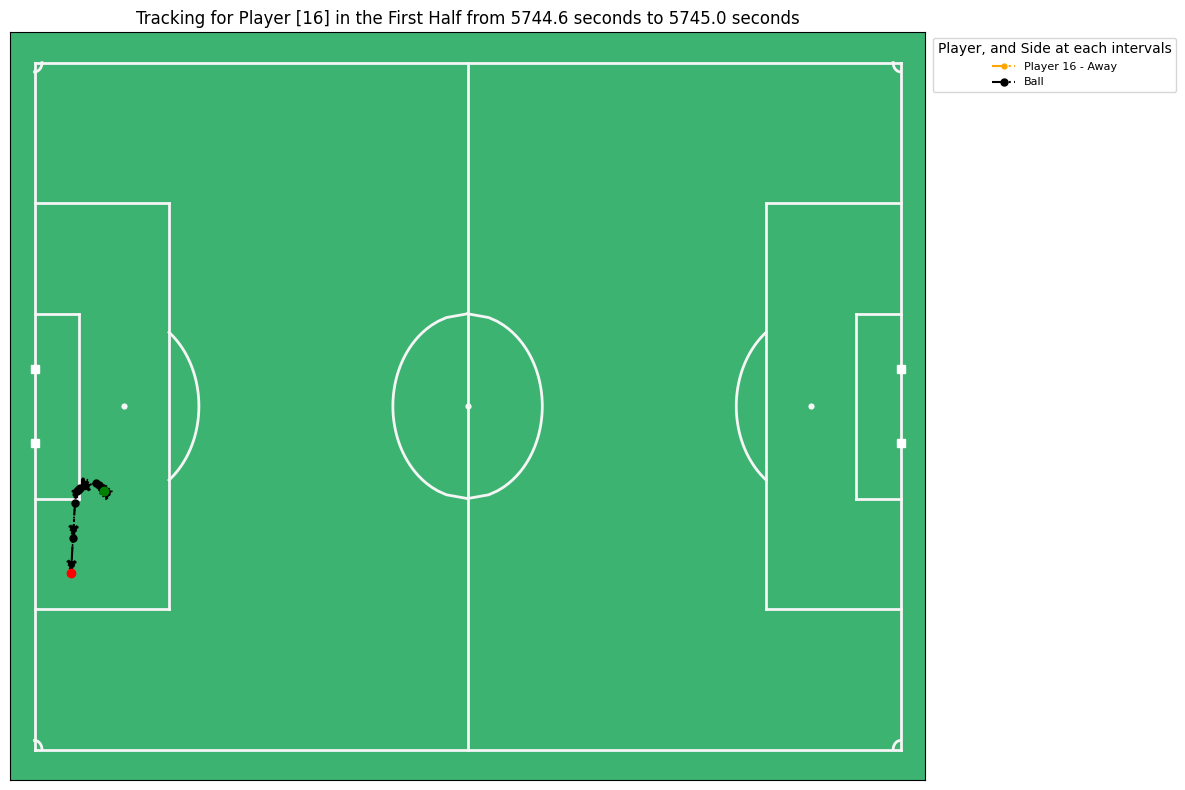

In [6]:
sides = ["Home"] * 11 + ["Away"] * 11
players = list(range(1, 12)) + list(range(15, 26))
game_2_pre.player_visualization(game_1_data.loc[143615:143625], players=[16], sides=["Away"], plot_ball=True)
# game_2_pre.player_visualization(game_2_data.iloc[2:3], players=[1,2,3,4,5,6,7,8,9,10,11], sides=["Home"]*11, plot_ball=False)

In [7]:
# player_tracking(period_1_data)
# player_tracking(period_1_data_home, [2])
# player_tracking(period_1_data_home, [5])
# player_tracking(period_1_data_home, [8])

# Adding extra features to dataset

In [8]:
vel_acc_game_1_data = calculate_velocity_acceleration(game_1_data)
vel_acc_game_2_data = calculate_velocity_acceleration(game_2_data)

In [9]:
vel_acc_game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,1.0,1.0,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,2.0,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,1.151215,NaN
3,1.0,3.0,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.123138,-0.701914
4,1.0,4.0,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,0.011138,0.278458,0.019121,0.478033,0.015201,0.380019,0.029611,0.740275,0.415521,-17.690434
5,1.0,5.0,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,0.008515,-0.065591,0.011560,-0.189042,0.022103,0.172568,0.029100,-0.012774,0.417319,0.044937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,2.0,145002.0,5800.08,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,...,0.010198,0.098326,0.002704,0.017604,0.013613,0.028951,0.017509,0.062515,0.000000,0.000000
145003,2.0,145003.0,5800.12,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,...,0.004031,-0.154173,0.011319,0.215377,0.014346,0.018330,0.022407,0.122446,0.000000,0.000000
145004,2.0,145004.0,5800.16,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,...,0.009394,0.134075,0.007906,-0.085338,0.013829,-0.012921,0.009100,-0.332665,0.000000,0.000000
145005,2.0,145005.0,5800.20,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,...,0.013500,0.102646,0.013440,0.138350,0.015004,0.029371,0.007754,-0.033653,0.000000,0.000000


In [10]:
vel_acc_game_2_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,1.0,1.0,0.04,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,2.0,0.08,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.00000,NaN,0.000000,NaN,0.0,NaN,0.0,NaN,0.0,NaN
3,1.0,3.0,0.12,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,4.0,0.16,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,5.0,0.20,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,2.0,141152.0,5646.08,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.00875,0.06250,0.010000,-0.027615,0.0,0.0,0.0,0.0,0.0,0.0
141153,2.0,141153.0,5646.12,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.00975,0.02500,0.006951,-0.076232,0.0,0.0,0.0,0.0,0.0,0.0
141154,2.0,141154.0,5646.16,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.00700,-0.06875,0.016623,0.241798,0.0,0.0,0.0,0.0,0.0,0.0
141155,2.0,141155.0,5646.20,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.00925,0.05625,0.009014,-0.190219,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
game_1_ply_tra = vel_acc_game_1_data.iloc[:, 3:]
game_2_ply_tra = vel_acc_game_2_data.iloc[:, 3:]

In [12]:
game_2_ply_tra

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.00000,NaN,0.000000,NaN,0.0,NaN,0.0,NaN,0.0,NaN
3,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.00875,0.06250,0.010000,-0.027615,0.0,0.0,0.0,0.0,0.0,0.0
141153,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.00975,0.02500,0.006951,-0.076232,0.0,0.0,0.0,0.0,0.0,0.0
141154,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.00700,-0.06875,0.016623,0.241798,0.0,0.0,0.0,0.0,0.0,0.0
141155,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.00925,0.05625,0.009014,-0.190219,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# game_1_players, game_1_vel_acc = game_1_ply_tra.loc[:,"Home-P_1-x":"Away-P_24-y"], game_1_ply_tra.loc[:,"P_1_velocity":]
# game_2_players, game_2_vel_acc = game_2_ply_tra.loc[:,"Home-P_1-x":"Away-P_24-y"], game_2_ply_tra.loc[:,"P_1_velocity":]

In [13]:
game_1_player_data = get_frame_data(game_1_ply_tra, columns=game_1_ply_tra.columns[0:46:2]).round(4).fillna(0)
game_2_player_data = get_frame_data(game_2_ply_tra, columns=game_2_ply_tra.columns[0:46:2]).round(4).fillna(0)

In [14]:
# game_1_player_data = game_1_data.iloc[:, 3:]
# game_2_player_data = game_2_data.iloc[:, 3:]

# Classification

In [15]:
game_1_event_data = pd.read_csv("data/Sample_Game_1/Sample_Game_1_RawEventsData.csv")
game_2_event_data = pd.read_csv("data/Sample_Game_2/Sample_Game_2_RawEventsData.csv")

game_1_event_data = game_1_event_data[~(game_1_event_data["Type"] == "FAULT RECEIVED")]
game_2_event_data = game_2_event_data[~(game_2_event_data["Type"] == "FAULT RECEIVED")]

game_1_event_data = game_1_event_data.replace("RECOVERY", "BALL LOST")
game_2_event_data = game_2_event_data.replace("RECOVERY", "BALL LOST")

game_1_event_data = game_1_event_data[["Type", "Start Frame", "End Frame", "From", "To"]]
game_2_event_data = game_2_event_data[["Type", "Start Frame", "End Frame", "From", "To"]]

In [16]:
game_1_event_data

,Type,Start Frame,End Frame,From,To
0,SET PIECE,1,0,Player19,NaN
1,PASS,1,3,Player19,Player21
2,PASS,3,17,Player21,Player15
3,PASS,45,61,Player15,Player19
4,PASS,77,96,Player19,Player21
...,...,...,...,...,...
1740,PASS,143361,143483,Player12,Player13
1741,PASS,143578,143593,Player13,Player4
1742,BALL LOST,143598,143618,Player4,NaN
1743,BALL LOST,143617,143617,Player16,NaN


In [17]:
game_2_event_data

,Type,Start Frame,End Frame,From,To
0,SET PIECE,51,51,Player23,NaN
1,PASS,51,87,Player23,Player20
2,PASS,146,186,Player20,Player18
3,PASS,248,283,Player18,Player17
4,PASS,316,346,Player17,Player16
...,...,...,...,...,...
1930,BALL LOST,140122,140183,Player21,NaN
1931,CHALLENGE,140180,140180,Player1,NaN
1932,CHALLENGE,140183,140183,Player24,NaN
1933,BALL LOST,140211,140211,Player12,NaN


In [19]:
def fix_events(event_dataset):
    fixed_event_df = event_dataset.copy()
    
    start_frames = fixed_event_df["Start Frame"].values
    end_frames = fixed_event_df["End Frame"].values
    
    conflict_indices = np.where(start_frames[1:] == end_frames[:-1])[0] + 1
    
    fixed_event_df.loc[fixed_event_df.index[conflict_indices], "Start Frame"] += 1
    
    return fixed_event_df

In [20]:
# game_1_event_data = fix_events(game_1_event_data)
# game_2_event_data = fix_events(game_2_event_data)

In [21]:
game_1_event_data

,Type,Start Frame,End Frame,From,To
0,SET PIECE,1,0,Player19,NaN
1,PASS,1,3,Player19,Player21
2,PASS,3,17,Player21,Player15
3,PASS,45,61,Player15,Player19
4,PASS,77,96,Player19,Player21
...,...,...,...,...,...
1740,PASS,143361,143483,Player12,Player13
1741,PASS,143578,143593,Player13,Player4
1742,BALL LOST,143598,143618,Player4,NaN
1743,BALL LOST,143617,143617,Player16,NaN


In [22]:
game_1_event = process_event_data(game_1_event_data, game_1_data)
game_2_event = process_event_data(game_2_event_data, game_2_data)

In [23]:
game_1_event

,Type
1,PASS
2,PASS
3,PASS
4,PASS
5,PASS
...,...
143614,BALL LOST
143615,BALL LOST
143616,BALL LOST
143617,BALL LOST


In [24]:
game_2_event

,Type
51,PASS
52,PASS
53,PASS
54,PASS
55,PASS
...,...
141152,BALL OUT
141153,BALL OUT
141154,BALL OUT
141155,BALL OUT


In [25]:
# game_1_event = game_1_event[~(game_1_event["Type"] == "CARD")]
# game_2_event = game_2_event[~(game_2_event["Type"] == "CARD")]143622	5744.88	143630

In [26]:
valid_indices = game_1_event.index.intersection(game_1_player_data.index)
X_1 = game_1_player_data.loc[valid_indices]
y_1 = game_1_event.loc[valid_indices]

In [27]:
valid_indices = game_2_event.index.intersection(game_2_player_data.index)
X_2 = game_2_player_data.loc[valid_indices]
y_2 = game_2_event.loc[valid_indices]

In [28]:
X_1

,Home-Player11-x,Home-Player11-y,P_11_velocity,P_11_acceleration,Home-Player1-x,Home-Player1-y,P_1_velocity,P_1_acceleration,Home-Player2-x,Home-Player2-y,...,P_23_velocity,P_23_acceleration,Away-Player24-x,Away-Player24-y,P_24_velocity,P_24_acceleration,Ball-x,Ball-y,Ball_velocity,Ball_acceleration
1,0.0008,0.4824,0.0000,0.0000,0.3265,0.6532,0.0000,0.0000,0.3370,0.4886,...,0.0000,0.0000,-0.3783,-0.2738,0.0000,0.0000,0.4547,0.3871,0.0000,0.0000
2,0.0010,0.4824,0.0035,0.0000,0.3265,0.6532,0.0000,0.0000,0.3370,0.4886,...,0.0000,0.0000,-0.3783,-0.2738,0.0000,0.0000,0.4964,0.4066,1.1512,0.0000
3,0.0011,0.4824,0.0045,0.0250,0.3265,0.6532,0.0000,0.0000,0.3370,0.4886,...,0.0000,0.0000,-0.3783,-0.2738,0.0000,0.0000,0.5372,0.4256,1.1231,-0.7019
4,0.0012,0.4824,0.0017,-0.0687,0.3262,0.6532,0.0066,0.1655,0.3369,0.4899,...,0.0152,0.3800,-0.3776,-0.2747,0.0296,0.7403,0.5535,0.4223,0.4155,-17.6904
5,0.0013,0.4824,0.0020,0.0063,0.3260,0.6527,0.0135,0.1728,0.3366,0.4902,...,0.0221,0.1726,-0.3766,-0.2754,0.0291,-0.0128,0.5551,0.4057,0.4173,0.0449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143614,0.8762,0.4889,0.0074,-0.0045,0.2515,0.5482,0.0138,-0.0061,0.4720,0.4482,...,0.0226,-0.0828,-0.2991,-0.5616,0.0500,-0.0147,0.0838,0.6271,0.1269,-0.0039
143615,0.8760,0.4891,0.0073,-0.0044,0.2510,0.5482,0.0128,-0.0247,0.4716,0.4484,...,0.0217,-0.0225,-0.2972,-0.5620,0.0492,-0.0196,0.0806,0.6231,0.1271,0.0039
143616,0.8758,0.4893,0.0071,-0.0036,0.2504,0.5482,0.0128,-0.0003,0.4712,0.4487,...,0.0213,-0.0101,-0.2953,-0.5623,0.0486,-0.0135,0.0774,0.6192,0.1269,-0.0039
143617,0.8756,0.4895,0.0071,-0.0007,0.2500,0.5483,0.0124,-0.0096,0.4708,0.4490,...,0.0231,0.0465,-0.2934,-0.5627,0.0485,-0.0023,0.0742,0.6152,0.1273,0.0088


In [29]:
def create_segments_multifeature(data, label, segment_length):
    inputs = []
    outputs = []
    
    assert len(data) == len(label), "Data and label lengths must match"
    
    for i in range(0, len(data) - segment_length + 1, segment_length):
        input_segment = data.iloc[i:i + segment_length].values
        label_segment = label.iloc[i:i + segment_length].values
        
        if len(input_segment) == segment_length:
            inputs.append(input_segment)
            outputs.append(label_segment)
            
    return np.array(inputs), np.array(outputs)

# New Dataset

In [30]:
game_3_data = pd.read_csv("data/Sample_Game_3/Sample_Game_3_tracking.txt", sep=r"[;,:]", header=None, engine="python")
game_3_data.index =  range(1, len(game_3_data) + 1)

In [31]:
time = np.arange(0.04, (len(game_3_data) + 1) * 0.04, 0.04).round(2)
game_3_data.insert(1, "Time [s]", time)

In [32]:
columns = ['Frame', 'Time [s]', 'Home-Player11-x', 'Home-Player11-y', 'Home-Player1-x', 'Home-Player1-y', 'Home-Player2-x', 'Home-Player2-y',
       'Home-Player3-x', 'Home-Player3-y', 'Home-Player4-x', 'Home-Player4-y', 'Home-Player5-x', 'Home-Player5-y', 'Home-Player6-x', 'Home-Player6-y',
       'Home-Player7-x', 'Home-Player7-y', 'Home-Player8-x', 'Home-Player8-y', 'Home-Player9-x', 'Home-Player9-y', 'Home-Player10-x',
       'Home-Player10-y', 'Away-Player25-x', 'Away-Player25-y', 'Away-Player15-x', 'Away-Player15-y', 'Away-Player16-x',
       'Away-Player16-y', 'Away-Player17-x', 'Away-Player17-y', 'Away-Player18-x', 'Away-Player18-y', 'Away-Player19-x',
       'Away-Player19-y', 'Away-Player20-x', 'Away-Player20-y', 'Away-Player21-x', 'Away-Player21-y', 'Away-Player22-x',
       'Away-Player22-y', 'Away-Player23-x', 'Away-Player23-y', 'Away-Player24-x', 'Away-Player24-y', "Ball-x", "Ball-y"]

game_3_data.columns = columns

In [33]:
game_3_data

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,0.41787,0.48086,0.41215,0.36689,0.47050,0.73219,0.48864,0.36357,NaN,NaN
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,0.41719,0.47864,0.41132,0.36169,0.47040,0.73204,0.48834,0.36362,NaN,NaN
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,0.41697,0.47824,0.41131,0.36072,0.47075,0.73229,0.48814,0.36372,NaN,NaN
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,0.41685,0.47815,0.41117,0.35930,0.47118,0.73266,0.48793,0.36278,NaN,NaN
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,0.41669,0.47749,0.41120,0.35910,0.47163,0.73287,0.48784,0.36240,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,0.58877,0.56936,0.50218,0.65158,0.46978,0.62349,0.80792,0.27106,NaN,NaN
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,0.58787,0.56961,0.50180,0.65115,0.46970,0.62403,0.80712,0.27184,NaN,NaN
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,0.58668,0.57038,0.50116,0.65071,0.46929,0.62479,0.80582,0.27242,NaN,NaN
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,0.58525,0.57033,0.50031,0.65134,0.46866,0.62611,0.80444,0.27260,NaN,NaN


In [34]:
game_3_data = game_2_pre._fill_missing_with_interpolation_and_fill(game_3_data)
game_3_data.iloc[:, 24:-2] = -1 * game_3_data.iloc[:, 24:-2]
game_3_data

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,-0.41787,-0.48086,-0.41215,-0.36689,-0.47050,-0.73219,-0.48864,-0.36357,0.50125,0.48725
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,-0.41719,-0.47864,-0.41132,-0.36169,-0.47040,-0.73204,-0.48834,-0.36362,0.50125,0.48725
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,-0.41697,-0.47824,-0.41131,-0.36072,-0.47075,-0.73229,-0.48814,-0.36372,0.50125,0.48725
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,-0.41685,-0.47815,-0.41117,-0.35930,-0.47118,-0.73266,-0.48793,-0.36278,0.50125,0.48725
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,-0.41669,-0.47749,-0.41120,-0.35910,-0.47163,-0.73287,-0.48784,-0.36240,0.50125,0.48725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,-0.58877,-0.56936,-0.50218,-0.65158,-0.46978,-0.62349,-0.80792,-0.27106,0.89207,0.50485
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,-0.58787,-0.56961,-0.50180,-0.65115,-0.46970,-0.62403,-0.80712,-0.27184,0.89207,0.50485
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,-0.58668,-0.57038,-0.50116,-0.65071,-0.46929,-0.62479,-0.80582,-0.27242,0.89207,0.50485
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,-0.58525,-0.57033,-0.50031,-0.65134,-0.46866,-0.62611,-0.80444,-0.27260,0.89207,0.50485


In [35]:
vel_acc_game_3_data = calculate_velocity_acceleration(game_3_data)
vel_acc_game_3_data

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,0.058045,NaN,0.131646,NaN,0.004507,NaN,0.007603,NaN,0.0,NaN
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,0.011413,-1.165813,0.024251,-2.684858,0.010753,0.156149,0.005590,-0.050332,0.0,0.0
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,0.003750,-0.191568,0.035672,0.285521,0.014182,0.085724,0.024079,0.462228,0.0,0.0
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,0.016978,0.330698,0.005056,-0.765405,0.012415,-0.044179,0.009763,-0.357912,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,0.016508,0.052893,0.012260,0.120679,0.006828,0.061555,0.016900,-0.017704,0.0,0.0
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,0.023352,0.171109,0.014346,0.052149,0.013647,0.170477,0.027933,0.275813,0.0,0.0
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,0.035435,0.302072,0.019416,0.126758,0.021588,0.198528,0.035588,0.191374,0.0,0.0
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,0.035772,0.008426,0.026450,0.175848,0.036566,0.374435,0.034792,-0.019892,0.0,0.0


In [36]:
game_3_ply_tra = vel_acc_game_3_data.iloc[:, 2:]
game_3_ply_tra

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,0.62405,0.80669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,0.62371,0.80594,...,0.058045,NaN,0.131646,NaN,0.004507,NaN,0.007603,NaN,0.0,NaN
3,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,0.62354,0.80601,...,0.011413,-1.165813,0.024251,-2.684858,0.010753,0.156149,0.005590,-0.050332,0.0,0.0
4,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,0.62318,0.80604,...,0.003750,-0.191568,0.035672,0.285521,0.014182,0.085724,0.024079,0.462228,0.0,0.0
5,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,0.62286,0.80626,...,0.016978,0.330698,0.005056,-0.765405,0.012415,-0.044179,0.009763,-0.357912,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,0.50927,0.27457,...,0.016508,0.052893,0.012260,0.120679,0.006828,0.061555,0.016900,-0.017704,0.0,0.0
143758,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,0.50913,0.27654,...,0.023352,0.171109,0.014346,0.052149,0.013647,0.170477,0.027933,0.275813,0.0,0.0
143759,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,0.50876,0.27762,...,0.035435,0.302072,0.019416,0.126758,0.021588,0.198528,0.035588,0.191374,0.0,0.0
143760,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,0.50808,0.27935,...,0.035772,0.008426,0.026450,0.175848,0.036566,0.374435,0.034792,-0.019892,0.0,0.0


In [37]:
game_3_player_data = get_frame_data(game_3_ply_tra, columns=game_3_ply_tra.columns[0:46:2]).round(4).fillna(0)
game_3_player_data

,Home-Player11-x,Home-Player11-y,P_11_velocity,P_11_acceleration,Home-Player1-x,Home-Player1-y,P_1_velocity,P_1_acceleration,Home-Player2-x,Home-Player2-y,...,P_23_velocity,P_23_acceleration,Away-Player24-x,Away-Player24-y,P_24_velocity,P_24_acceleration,Ball-x,Ball-y,Ball_velocity,Ball_acceleration
1,0.8472,0.5286,0.0,0.0,0.6527,0.2479,0.0000,0.0000,0.6652,0.4656,...,0.0000,0.0000,-0.4886,-0.3636,0.0000,0.0000,0.5012,0.4872,0.0,0.0
2,0.8472,0.5286,0.0,0.0,0.6523,0.2451,0.0704,0.0000,0.6648,0.4655,...,0.0045,0.0000,-0.4883,-0.3636,0.0076,0.0000,0.5012,0.4872,0.0,0.0
3,0.8472,0.5286,0.0,0.0,0.6520,0.2439,0.0326,-0.9434,0.6647,0.4654,...,0.0108,0.1561,-0.4881,-0.3637,0.0056,-0.0503,0.5012,0.4872,0.0,0.0
4,0.8472,0.5286,0.0,0.0,0.6517,0.2429,0.0259,-0.1673,0.6646,0.4649,...,0.0142,0.0857,-0.4879,-0.3628,0.0241,0.4622,0.5012,0.4872,0.0,0.0
5,0.8472,0.5286,0.0,0.0,0.6514,0.2425,0.0112,-0.3693,0.6645,0.4647,...,0.0124,-0.0442,-0.4878,-0.3624,0.0098,-0.3579,0.5012,0.4872,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,0.1199,0.5178,0.0,0.0,0.4781,0.4541,0.0175,0.2063,0.4969,0.7731,...,0.0068,0.0616,-0.8079,-0.2711,0.0169,-0.0177,0.8921,0.5048,0.0,0.0
143758,0.1199,0.5178,0.0,0.0,0.4779,0.4552,0.0288,0.2816,0.4970,0.7743,...,0.0136,0.1705,-0.8071,-0.2718,0.0279,0.2758,0.8921,0.5048,0.0,0.0
143759,0.1199,0.5178,0.0,0.0,0.4774,0.4571,0.0482,0.4858,0.4969,0.7756,...,0.0216,0.1985,-0.8058,-0.2724,0.0356,0.1914,0.8921,0.5048,0.0,0.0
143760,0.1199,0.5178,0.0,0.0,0.4767,0.4595,0.0623,0.3524,0.4968,0.7764,...,0.0366,0.3744,-0.8044,-0.2726,0.0348,-0.0199,0.8921,0.5048,0.0,0.0


In [38]:
# game_3_player_data = game_3_data.iloc[:, 2:]

In [39]:
with open("data/Sample_Game_3/Sample_Game_3_events.json", "r") as f:
    data = json.load(f)

In [40]:
type_ = np.array([])
start_frame = np.array([])
end_frame = np.array([])

for i in data["data"]:
    t = i["type"]["name"]
    sf = i["start"]["frame"]
    ef = i["end"]["frame"]

    if t != "CARRY" and t != "BALL OUT":
        type_ = np.append(type_, t)
        start_frame = np.append(start_frame, sf)
        end_frame = np.append(end_frame, ef)


game_3_event_data = pd.DataFrame({"Type": type_, "Start Frame": start_frame.astype(np.int64), "End Frame": end_frame.astype(np.int64)})

In [41]:
game_3_event_data = game_3_event_data[~(game_3_event_data["Type"] == "FAULT RECEIVED")]

game_3_event_data = game_3_event_data.replace("RECOVERY", "BALL LOST")

In [42]:
game_3_event_data

,Type,Start Frame,End Frame
0,SET PIECE,361,361
1,PASS,361,377
2,PASS,384,426
3,PASS,465,507
4,PASS,530,580
...,...,...,...
2156,PASS,143190,143265
2157,PASS,143265,143290
2158,PASS,143406,143469
2159,PASS,143469,143532


In [43]:
game_3_event = process_event_data(game_3_event_data, game_3_data)
game_3_event

,Type
361,PASS
362,PASS
363,PASS
364,PASS
365,PASS
...,...
143529,PASS
143530,PASS
143531,PASS
143532,PASS


In [44]:
# game_3_event = game_3_event[~(game_3_event["Type"] == "CARD")]
# game_3_event

In [45]:
# with open("model.pickle", "rb") as f:
#     loaded_model = pickle.load(f)

In [46]:
valid_indices = game_3_event.index.intersection(game_3_player_data.index)
X_3 = game_3_player_data.loc[valid_indices]
y_3 = game_3_event.loc[valid_indices]

assert X_3.shape[0] == y_3.shape[0]

In [47]:
X_3

,Home-Player11-x,Home-Player11-y,P_11_velocity,P_11_acceleration,Home-Player1-x,Home-Player1-y,P_1_velocity,P_1_acceleration,Home-Player2-x,Home-Player2-y,...,P_23_velocity,P_23_acceleration,Away-Player24-x,Away-Player24-y,P_24_velocity,P_24_acceleration,Ball-x,Ball-y,Ball_velocity,Ball_acceleration
361,0.8422,0.5168,0.0088,-0.1068,0.6386,0.1946,0.0122,-0.0176,0.7347,0.3860,...,0.0154,0.0679,-0.4871,-0.3631,0.0048,0.0273,0.5012,0.4872,0.0000,0.0000
362,0.8423,0.5165,0.0086,-0.0036,0.6383,0.1942,0.0135,0.0312,0.7349,0.3867,...,0.0149,-0.0139,-0.4873,-0.3631,0.0045,-0.0070,0.5011,0.4872,0.0035,0.0877
363,0.8425,0.5162,0.0081,-0.0146,0.6379,0.1940,0.0107,-0.0694,0.7350,0.3874,...,0.0166,0.0424,-0.4875,-0.3630,0.0054,0.0217,0.5010,0.4872,0.0040,0.0125
364,0.8426,0.5158,0.0101,0.0507,0.6376,0.1936,0.0115,0.0201,0.7352,0.3879,...,0.0150,-0.0378,-0.4878,-0.3630,0.0063,0.0218,0.5008,0.4872,0.0040,0.0006
365,0.8428,0.5155,0.0105,0.0109,0.6373,0.1933,0.0108,-0.0171,0.7353,0.3885,...,0.0166,0.0395,-0.4881,-0.3631,0.0078,0.0371,0.5006,0.4872,0.0040,-0.0006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143529,0.1199,0.5178,0.0000,0.0000,0.4281,0.4874,0.0173,0.0295,0.4386,0.7978,...,0.0080,-0.0042,-0.7547,-0.2033,0.0330,0.0328,0.8771,0.5331,0.1522,0.0000
143530,0.1199,0.5178,0.0000,0.0000,0.4287,0.4870,0.0178,0.0125,0.4390,0.7972,...,0.0082,0.0061,-0.7558,-0.2026,0.0326,-0.0092,0.8798,0.5277,0.1521,-0.0028
143531,0.1199,0.5178,0.0000,0.0000,0.4293,0.4866,0.0186,0.0191,0.4393,0.7965,...,0.0084,0.0034,-0.7569,-0.2018,0.0347,0.0515,0.8826,0.5222,0.1522,0.0028
143532,0.1199,0.5178,0.0000,0.0000,0.4299,0.4862,0.0185,-0.0021,0.4396,0.7960,...,0.0080,-0.0087,-0.7580,-0.2010,0.0345,-0.0045,0.8853,0.5168,0.1522,0.0000


In [48]:
np.unique(y_1, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'CARD', 'CHALLENGE', 'PASS', 'SET PIECE',
        'SHOT'], dtype=object),
 array([10042, 19023,     4,   132, 28127,    13,   546], dtype=int64))

In [49]:
np.unique(y_2, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'CARD', 'CHALLENGE', 'PASS', 'SET PIECE',
        'SHOT'], dtype=object),
 array([ 7713, 15537,     6,   174, 32340,     6,   482], dtype=int64))

In [50]:
np.unique(y_3, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'CARD', 'CHALLENGE', 'PASS', 'SHOT'],
       dtype=object),
 array([11060, 19620,     1,   192, 42858,   390], dtype=int64))

In [51]:
scaler = MinMaxScaler()
X_1_scaled = X_1.iloc[:, :].values#scaler.fit_transform(X_1)
X_2_scaled = X_2.iloc[:, :].values#scaler.transform(X_2)
X_3_scaled = X_3.iloc[:, :].values#scaler.transform(X_3)

# X_1_scaled = minmax_scale(X_1, axis=1)
# X_2_scaled = minmax_scale(X_2, axis=1)
# X_3_scaled = minmax_scale(X_3, axis=1)

# label_encoder = LabelEncoder()
# y_1_encoded = label_encoder.fit_transform(y_1)
# y_2_encoded = label_encoder.transform(y_2)
# y_3_encoded = label_encoder.transform(y_3)

In [52]:
print(X_1_scaled.shape)
print(X_2_scaled.shape)
print(X_3_scaled.shape)

(57887, 92)
(56258, 92)
(74121, 92)


In [53]:
X_1_scaled[603]

array([ 0.1181,  0.4845,  0.0049, -0.0033,  0.5379,  0.7285,  0.0272,
       -0.0167,  0.4805,  0.612 ,  0.0259,  0.0087,  0.4958,  0.45  ,
        0.0267, -0.    ,  0.5829,  0.2477,  0.016 , -0.0183,  0.9125,
        0.5957,  0.0465, -0.0448,  0.6546,  0.5456,  0.0404, -0.027 ,
        0.7105,  0.3517,  0.0378, -0.018 ,  0.9583,  0.1871,  0.0799,
       -0.009 ,  0.9446,  0.4093,  0.0586, -0.0394,  0.8005,  0.5402,
        0.0207, -0.0532, -0.9981, -0.4158,  0.0016, -0.09  , -0.945 ,
       -0.2477,  0.0474, -0.0138, -0.9572, -0.4151,  0.0277, -0.1858,
       -0.9278, -0.5203,  0.0271, -0.0389, -0.8826, -0.323 ,  0.0367,
        0.0098, -0.8355, -0.441 ,  0.0325, -0.0248, -0.8684, -0.5279,
        0.0377, -0.0204, -0.6757, -0.6229,  0.0379, -0.0154, -0.6798,
       -0.6805,  0.0533, -0.0052, -0.5302, -0.5734,  0.0293,  0.0029,
       -0.5256, -0.4261,  0.0148,  0.0059,  1.0003,  0.2027,  0.1044,
       -0.0034])

In [54]:
X = np.concatenate([X_1_scaled, X_2_scaled])
y = np.concatenate((y_1, y_2))

assert X.shape[0] == y.shape[0]

In [55]:
models = {
      # "AdaBoost classifier": AdaBoostClassifier(random_state=42), 
      # "Logistic regression": LogisticRegression(solver="saga", random_state=42),
      # "Gaussian naive bayes": GaussianNB(),
      "Random forest classifier": RandomForestClassifier(n_jobs=-1, random_state=42), 
      # "Neural network": MLPClassifier(hidden_layer_sizes=(32, 32, 32, 16, 16,), learning_rate="adaptive", random_state=42), 
    }

C:\Users\noill\OneDrive\Desktop\module\Masters Thesis\Thesis\Real-Time LLM Football Commentary\.venv\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\noill\OneDrive\Desktop\module\Masters Thesis\Thesis\Real-Time LLM Football Commentary\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


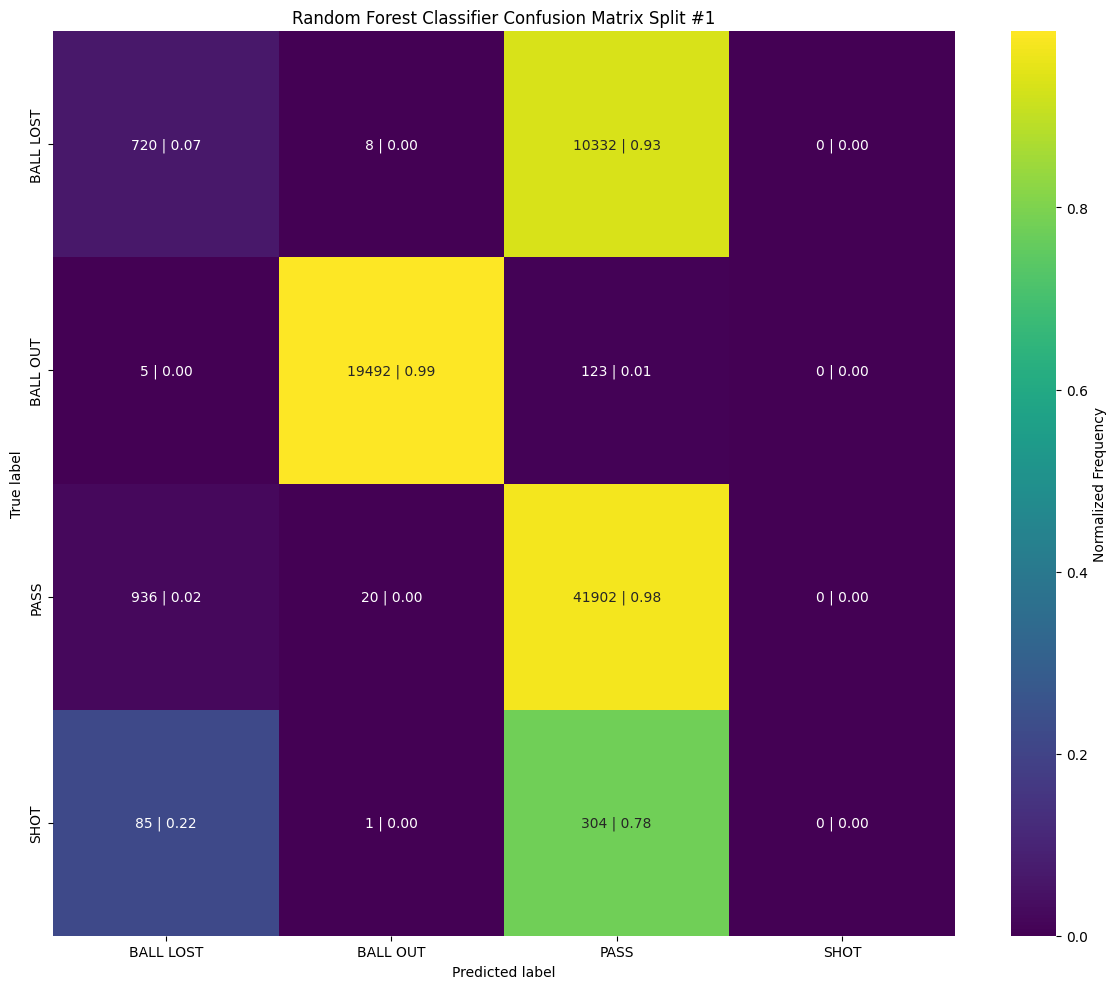

Random forest classifier training accuracy: 100.00%
Random forest classifier testing accuracy: 83.80%

Random forest classifier testing precision: 78.39%
Random forest classifier testing recall: 83.80%
Random forest classifier testing f1: 78.67%




In [56]:
# for i in range(len(scaled["X_train"])):
for name, model in models.items():
    # X_train_scaled = scaled["X_train"][0]
    # X_test_scaled = scaled["X_test"][0]
    # y_train = scaled["y_train"][0]
    # y_test = scaled["y_test"][0]

    model.fit(X, y)
    y_train_pred = model.predict(X)
    y_pred = model.predict(X_3)    
    labels = np.unique(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'])
    
    plot_confusion_matrix(y_train=y, y_train_pred=y_train_pred, y_test=y_3, y_pred=y_pred, labels=labels, split=0, model_name=name)
    
    # print("\n")